In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
from tqdm.auto import tqdm
import numpy as np
from torch_geometric.data import Data
import torch
import pickle
import pandas as pd

from nodalinterchange.utils.trainer import Trainer
from nodalinterchange.nets.convnet import ConvNet
from nodalinterchange.utils.loss_functions import arc_loss
from nodalinterchange.utils.model import Model
from nodalinterchange.utils.dataset import Dataset
from nodalinterchange.utils.datautils import evaluate_all, bins_from_edges, cart2polar, polar2cart, get_bands

In [5]:
train_set = Dataset([
#     '/remote/ceph2/user/h/haminh/GraphNet/input/l3_training/120000/i3cols/',
    '/remote/ceph2/user/h/haminh/GraphNet/input/l3_training/140000/i3cols/',
#     '/remote/ceph2/user/h/haminh/GraphNet/input/l3_training/160000/i3cols/',
                    ],
#     recalculate_energies=True, 
#     save_energies=True
)

Getting muon indices: 100%|██████████| 1800244/1800244 [00:39<00:00, 46029.82it/s]


In [10]:
sinz = np.array([np.sin(train_set.get_truths()['zenith'])], 
                    dtype=[('sin(z)', float)])

In [9]:
train_set.add_truth(sinz)

In [10]:
train_config = {
    'learning_rate': 1e-3,
#     'learning_rate': 7e-4,
    'scheduling_step_size': 10,
    'scheduling_gamma': .7,
    'training_target': ['sin(z)', 'z_dir'],
    'dataset': train_set,
    'train_split': 2e5,
    'validation_split': 1024*4,
    'test_split': 1e5,
    'batch_size': 512,
    'max_epochs': 100,
    'plot': 'save',
    'loss_function': torch.nn.MSELoss(),
    'plot_filename': 'cartesian_DC.pdf',
#     'final_activation': torch.tanh,
#     'normalize_output':True,
#     'weights': 'smpl_weights',
#     'weighted_validation': False,
#     'net': net,
}

In [11]:
trainer = Trainer(train_config)

In [12]:
trainer.train()

KeyboardInterrupt: 

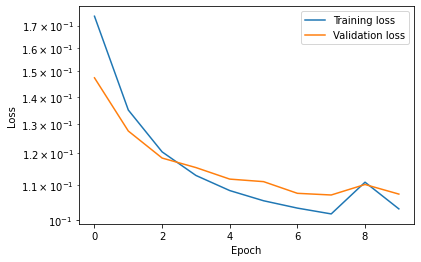

In [13]:
%matplotlib inline
import numpy as np
plt.figure()
plt.plot(np.arange(len(trainer.train_losses)), trainer.train_losses, label='Training loss')
plt.plot(np.arange(len(trainer.train_losses)), trainer.validation_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [14]:
trainer.load_best_model()

In [15]:
prediction = trainer.evaluate_test_samples()

In [16]:
test_zenith = trainer.test_truths['zenith'][:len(prediction)]

In [17]:
prediction_zenith = np.arctan2(*prediction.T)

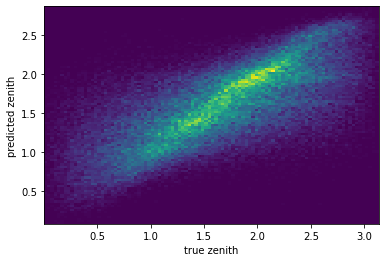

In [33]:
axis=1
plt.figure()
plt.hist2d((test_zenith), (prediction_zenith), bins=100)
plt.xlabel('true zenith')
plt.ylabel('predicted zenith')
plt.show()

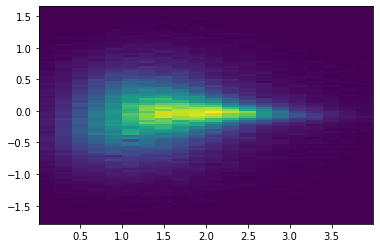

In [19]:
plt.figure()
hist_1 = plt.hist2d(trainer.test_truths['log10(energy)'],
          np.cos(test_zenith)- np.cos(prediction_zenith),
          bins=[20, 100])
plt.show()

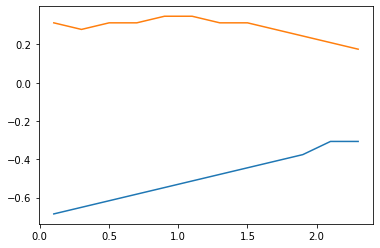

In [20]:
bands =  get_bands(hist_1)
plt.figure()
lim = 12
plt.plot(bins_from_edges(hist_1[1])[:12], bands[0][:12])
plt.plot(bins_from_edges(hist_1[1])[:12], bands[1][:12])
plt.show()

In [22]:
trainer.save_network_info('./results/test.pkl')

In [23]:
info = pickle.load(open('./results/test.pkl', 'rb'), encoding='latin1')

In [24]:
m = Model(info)

In [25]:
test_set = Dataset(['/remote/ceph2/user/h/haminh/GraphNet/input/l7/140000/i3cols/'], recalculate_energies=True, save_energies=True)

Getting muon indices: 100%|██████████| 3879496/3879496 [01:29<00:00, 43304.03it/s]


In [26]:
info['normalization_parameters']

{'means': tensor([ 3.4679e+01, -3.0759e+01, -3.2995e+02,  1.0636e+04,  1.0747e+00]),
 'stds': tensor([ 104.7039,   97.0365,  116.0016, 1083.6440,    2.5133])}

In [27]:
test_set.set_normalization_parameters(info['normalization_parameters'])

/home/iwsatlas1/haminh/IceCube/NodalInterchange/nodalinterchange/utils/dataset.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._means = torch.tensor(means, dtype=torch.float)
/home/iwsatlas1/haminh/IceCube/NodalInterchange/nodalinterchange/utils/dataset.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._stds = torch.tensor(stds, dtype=torch.float)


In [28]:
selec = list(np.random.permutation(len(test_set))[:100000])

In [29]:
outp = trainer.model.evaluate_dataset(test_set[selec], 1024)

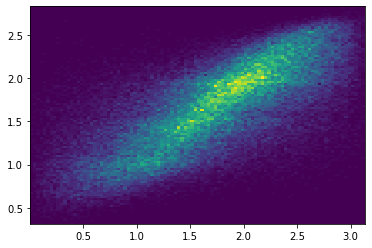

In [32]:
plt.figure()
plt.hist2d(test_set.get_truths()['zenith'][selec], 
           np.arctan2(*outp.T), bins=100)
plt.show()